# **AI-Based IT Ticketing Support System**

# 1. Install the required libraries

In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b5f5ba537a0c0fc5db7152706bda83293b81c6e786e15c39402cb2bab4af522f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
pip install sentence-transformers


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 36.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
import faiss
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 2. Data Loading and Preprocessing

In [7]:
# Load datasets
ticket_data = pd.read_csv('ticket_database.csv')
proposed_data = pd.read_csv('ticket_base_proposed.csv')

# Handling missing values
ticket_data.fillna('', inplace=True)

<ipython-input-8-433863f6af66>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ticket_data['Technical Level'].value_counts().index,
<ipython-input-8-433863f6af66>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ticket_data['Category'].value_counts().index,
<ipython-input-8-433863f6af66>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ticket_data['Emotional State'].value_counts().index,
<ipython-input-8-433863f6af66>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

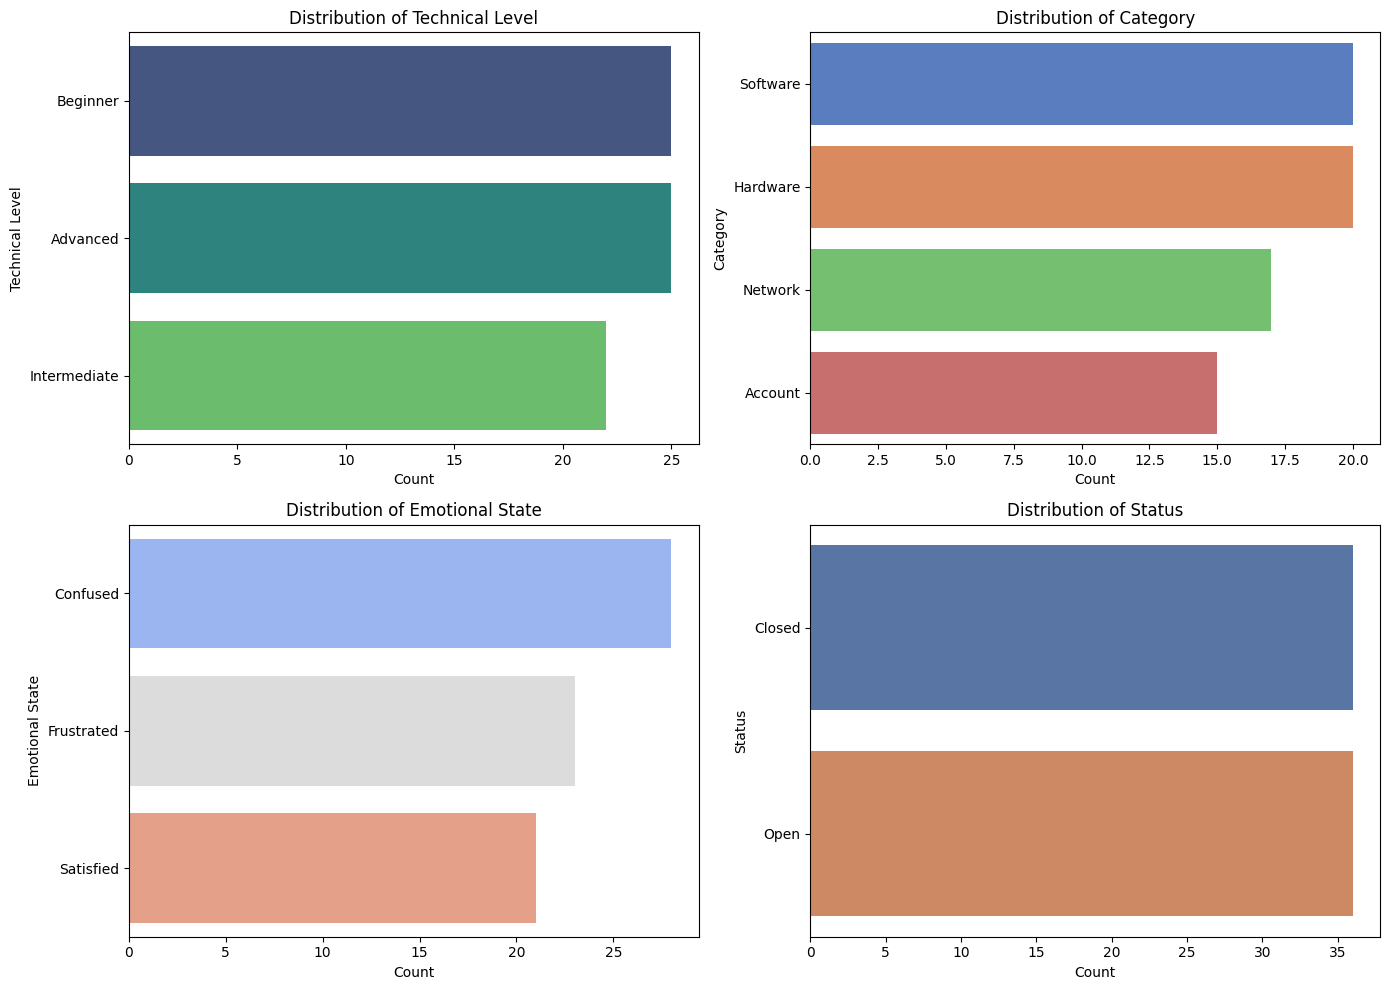

In [8]:
# Plot the distribution of categorical variables in ticket_database with horizontal bars
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(y=ticket_data['Technical Level'].value_counts().index,
            x=ticket_data['Technical Level'].value_counts().values, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribution of Technical Level')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Technical Level')

sns.barplot(y=ticket_data['Category'].value_counts().index,
            x=ticket_data['Category'].value_counts().values, ax=axes[0, 1], palette='muted')
axes[0, 1].set_title('Distribution of Category')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Category')

sns.barplot(y=ticket_data['Emotional State'].value_counts().index,
            x=ticket_data['Emotional State'].value_counts().values, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Distribution of Emotional State')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Emotional State')

sns.barplot(y=ticket_data['Status'].value_counts().index,
            x=ticket_data['Status'].value_counts().values, ax=axes[1, 1], palette='deep')
axes[1, 1].set_title('Distribution of Status')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Status')

plt.tight_layout()
plt.show()


# 3. Classification

In [9]:
# Encoding categorical variables
le_technical = LabelEncoder()
le_category = LabelEncoder()
le_emotional = LabelEncoder()

ticket_data['Technical Level Encoded'] = le_technical.fit_transform(ticket_data['Technical Level'])
ticket_data['Category Encoded'] = le_category.fit_transform(ticket_data['Category'])
ticket_data['Emotional State Encoded'] = le_emotional.fit_transform(ticket_data['Emotional State'])

In [10]:
# Splitting the data for classification tasks
X_train, X_test, y_train_tech, y_test_tech = train_test_split(ticket_data['FaQ'], ticket_data['Technical Level Encoded'], test_size=0.2, random_state=42)
_, _, y_train_cat, y_test_cat = train_test_split(ticket_data['FaQ'], ticket_data['Category Encoded'], test_size=0.2, random_state=42)
_, _, y_train_emo, y_test_emo = train_test_split(ticket_data['FaQ'], ticket_data['Emotional State Encoded'], test_size=0.2, random_state=42)

# 4. Train and Evaluate the Model

In [11]:
# Define parameter grids for hyperparameter tuning
param_grid_logistic = {'clf__C': [0.01, 0.1, 1, 10, 100], 'clf__solver': ['liblinear', 'lbfgs'], 'clf__max_iter': [100, 500, 1000]}
param_grid_random_forest = {'clf__n_estimators': [100, 200, 300], 'clf__max_depth': [None, 10, 20, 30]}
param_grid_svc = {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


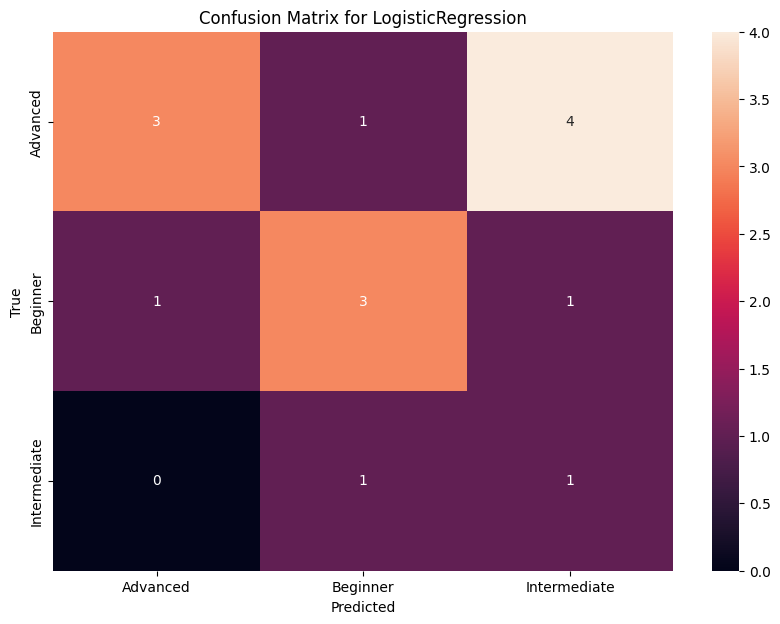

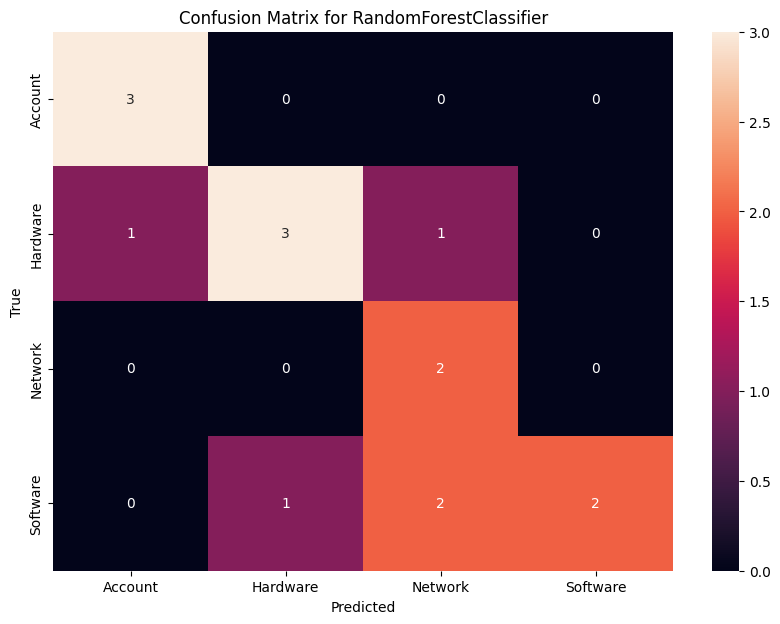

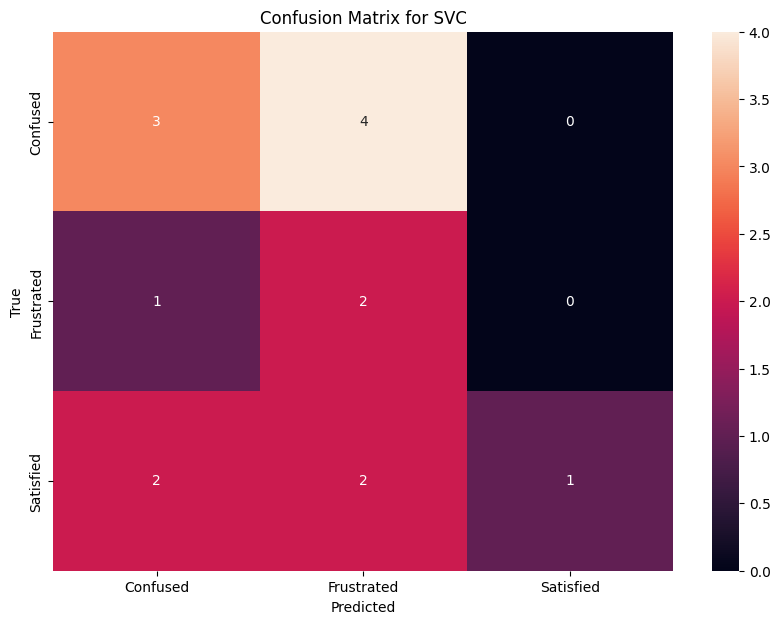

In [12]:
def train_evaluate_model_with_pipeline(X_train, y_train, X_test, y_test, target_names, model, param_grid, plot_confusion=False):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('clf', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)
    mcc = matthews_corrcoef(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)

    if plot_confusion:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {model.__class__.__name__}')
        plt.show()

    return best_model, accuracy, report, mcc, logloss

# Train and evaluate models, including MCC and Log-Loss calculation

tech_level_model, tech_accuracy, tech_report, tech_mcc, tech_logloss = train_evaluate_model_with_pipeline(
    X_train, y_train_tech, X_test, y_test_tech,
    target_names=le_technical.classes_,
    model=LogisticRegression(),
    param_grid=param_grid_logistic,
    plot_confusion=True
)

category_model, cat_accuracy, cat_report, cat_mcc, cat_logloss = train_evaluate_model_with_pipeline(
    X_train, y_train_cat, X_test, y_test_cat,
    target_names=le_category.classes_,
    model=RandomForestClassifier(),
    param_grid=param_grid_random_forest,
    plot_confusion=True
)

emotional_model, emo_accuracy, emo_report, emo_mcc, emo_logloss = train_evaluate_model_with_pipeline(
    X_train, y_train_emo, X_test, y_test_emo,
    target_names=le_emotional.classes_,
    model=SVC(probability=True),
    param_grid=param_grid_svc,
    plot_confusion=True
)

In [13]:
# Displaying metrics for Technical Level classification
print("Technical Level Classification:")
print(f"Accuracy: {tech_accuracy}")
print("Classification Report:")
print(tech_report)
print(f"Matthews Correlation Coefficient (MCC): {tech_mcc}")
print(f"Log-Loss: {tech_logloss}")

# Displaying metrics for Category classification
print("Category Classification:")
print(f"Accuracy: {cat_accuracy}")
print("Classification Report:")
print(cat_report)
print(f"Matthews Correlation Coefficient (MCC): {cat_mcc}")
print(f"Log-Loss: {cat_logloss}")

# Displaying metrics for Emotional State classification
print("Emotional State Classification:")
print(f"Accuracy: {emo_accuracy}")
print("Classification Report:")
print(emo_report)
print(f"Matthews Correlation Coefficient (MCC): {emo_mcc}")
print(f"Log-Loss: {emo_logloss}")

Technical Level Classification:
Accuracy: 0.4666666666666667
Classification Report:
              precision    recall  f1-score   support

    Advanced       0.75      0.38      0.50         8
    Beginner       0.60      0.60      0.60         5
Intermediate       0.17      0.50      0.25         2

    accuracy                           0.47        15
   macro avg       0.51      0.49      0.45        15
weighted avg       0.62      0.47      0.50        15

Matthews Correlation Coefficient (MCC): 0.25756371316446414
Log-Loss: 1.1212236376022808
Category Classification:
Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

     Account       0.75      1.00      0.86         3
    Hardware       0.75      0.60      0.67         5
     Network       0.40      1.00      0.57         2
    Software       1.00      0.40      0.57         5

    accuracy                           0.67        15
   macro avg       0.72      0.75      0.67

# 5. Semantic Search Setup using Sentence-BERT and FAISS

In [14]:
# Semantic search setup using Sentence-BERT and FAISS
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate embeddings for all FAQs in the ticket database
ticket_embeddings = model.encode(ticket_data['FaQ'].tolist())

# Build the FAISS index
dimension = ticket_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(ticket_embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 6. Problem Resolution Functions

In [15]:
def classify_problem(problem_statement):
    problem_tfidf = tech_level_model.named_steps['tfidf'].transform([problem_statement])
    tech_pred = tech_level_model.named_steps['clf'].predict(problem_tfidf)[0]
    cat_pred = category_model.named_steps['clf'].predict(problem_tfidf)[0]
    emo_pred = emotional_model.named_steps['clf'].predict(problem_tfidf)[0]

    return {
        'Technical Level': le_technical.inverse_transform([tech_pred])[0],
        'Category': le_category.inverse_transform([cat_pred])[0],
        'Emotional State': le_emotional.inverse_transform([emo_pred])[0]
    }

In [16]:
def explain_prediction(model, problem_statement):
    explainer = LimeTextExplainer(class_names=model.named_steps['clf'].classes_)
    exp = explainer.explain_instance(problem_statement, model.predict_proba, num_features=10)
    return exp

In [17]:
def find_solution(problem_statement):
    problem_embedding = model.encode([problem_statement])
    distances, indices = index.search(problem_embedding, 1)
    closest_match_idx = indices[0][0]

    return ticket_data.iloc[closest_match_idx]['Answer'], ticket_data.iloc[closest_match_idx]['Ticket_ID']

def recommend_solution(problem_statement):
    classification = classify_problem(problem_statement)
    solution, ticket_id = find_solution(problem_statement)

    return {
        'Classification': classification,
        'Recommended Solution': solution,
        'Ticket_ID': ticket_id
    }

In [18]:
def get_proposed_solution(error_code):
    proposed_solution_row = proposed_data[proposed_data['Error Code'] == error_code]
    if not proposed_solution_row.empty:
        return proposed_solution_row.iloc[0]['Proposed Solution'], proposed_solution_row.iloc[0]['Support Engineer'], proposed_solution_row.iloc[0]['Contact']
    else:
        # Return a default message along with the random support engineer
        solution, contact = get_random_support_engineer()
        return None, solution, contact

In [19]:
def get_random_support_engineer():
    random_engineer = proposed_data.sample(n=1).iloc[0]
    return random_engineer['Support Engineer'], random_engineer['Contact']

def update_support_engineer_assignment(ticket_id, customer_id, assigned_engineer, predicted_category):
    # Check if the file exists
    if os.path.exists('support_engineer_assignments.csv'):
        assignment_data = pd.read_csv('support_engineer_assignments.csv')
    else:
        assignment_data = pd.DataFrame(columns=['ticket_id', 'customer_id', 'assigned_engineer', 'predicted_category', 'status'])

    # Add new assignment
    new_assignment = pd.DataFrame({
        'ticket_id': [ticket_id],
        'customer_id': [customer_id],
        'assigned_engineer': [assigned_engineer],
        'predicted_category': [predicted_category],
        'status': ['Pending']
    })

    # Concatenate the new assignment to the existing data
    assignment_data = pd.concat([assignment_data, new_assignment], ignore_index=True)

    # Save the updated assignments
    assignment_data.to_csv('support_engineer_assignments.csv', index=False)


# 7. Main Application Flow

In [22]:
def main():
    print("Welcome to AI-Based IT Ticketing Support System!")

    while True:
        problem_statement = input("Please submit your request (or type 'exit' to quit): ")
        if problem_statement.lower() == 'exit':
            break
        recommendation = recommend_solution(problem_statement)

        # Determine the appropriate response based on the emotional state
        emotional_state = recommendation['Classification']['Emotional State']
        if emotional_state == 'Frustrated':
            emotional_response = "I'm sorry, I can see that you're frustrated. Let's try to resolve this quickly."
        elif emotional_state == 'Confused':
            emotional_response = "I can see that you're confused. I'll do my best to clarify things."
        elif emotional_state == "Satisfied":
            emotional_response = "Thanks for contacting us. We will help you immediately."

        print("\nClassification:")
        print(f"Technical Level: {recommendation['Classification']['Technical Level']}")
        print(f"Category: {recommendation['Classification']['Category']}")
        print(f"Emotional State: {recommendation['Classification']['Emotional State']}")

        tech_exp = explain_prediction(tech_level_model, problem_statement)
        cat_exp = explain_prediction(category_model, problem_statement)
        emo_exp = explain_prediction(emotional_model, problem_statement)

        print("\nExplanation of Technical Level Prediction:")
        print(tech_exp.as_list())

        print("\nExplanation of Category Prediction:")
        print(cat_exp.as_list())

        print("\nExplanation of Emotional State Prediction:")
        print(emo_exp.as_list())

        print("\n" + emotional_response)
        print("Ticket ID: " + str(recommendation['Ticket_ID']))
        print("Recommended Solution:")
        print(recommendation['Recommended Solution'])

        feedback = input("\nDid the solution work? (yes/no): ").strip().lower()
        if feedback == 'yes':
            print("Great! Your ticket is now closed. Have a good day!")
        else:
            error_code = input("Please provide the error code if available (or type 'skip' to continue): ").strip().upper()
            if error_code != 'skip':
                proposed_solution, engineer, contact = get_proposed_solution(error_code)
                if proposed_solution:
                    print("\nAdvanced Solution:")
                    print(f"Solution: {proposed_solution}")
                    feedback = input("\nDid the proposed advanced solution work? (yes/no): ").strip().lower()
                    if feedback == 'yes':
                        print("Great! Your ticket is now closed.")
                    else:
                        customer_id = input("Please enter your Customer ID: ").strip()
                        print(f"Please contact the support engineer for further assistance:\nSupport Engineer: {engineer}\nContact: {contact}")
                        update_support_engineer_assignment(recommendation['Ticket_ID'], customer_id, engineer, recommendation['Classification']['Category'])
                else:
                    customer_id = input("Please enter your Customer ID: ").strip()
                    print(f"Please contact the support engineer for further assistance:\nSupport Engineer: {engineer}\nContact: {contact}")
                    update_support_engineer_assignment(recommendation['Ticket_ID'], customer_id
                    , engineer, recommendation['Classification']['Category'])
            else:
                customer_id = input("Please enter your Customer ID: ").strip()
                engineer, contact = get_random_support_engineer()
                print(f"Please contact the support engineer for further assistance:\nSupport Engineer: {engineer}\nContact: {contact}")
                update_support_engineer_assignment(recommendation['Ticket_ID'], customer_id, engineer, recommendation['Classification']['Category'])
        print("\n")

if __name__ == "__main__":
    main()

Welcome to AI-Based IT Ticketing Support System!
Please submit your request (or type 'exit' to quit): I forgot my password

Classification:
Technical Level: Beginner
Category: Network
Emotional State: Satisfied

Explanation of Technical Level Prediction:
[('password', 0.32452170776993294), ('my', 0.16750386713760348), ('I', 0.03037063706519633), ('forgot', 0.02415510795246526)]

Explanation of Category Prediction:
[('my', 0.08347360578084526), ('password', -0.036323444891672683), ('I', 0.0006884375233010509), ('forgot', 0.0006839625428285498)]

Explanation of Emotional State Prediction:
[('password', -0.026096176748173196), ('my', -0.0187115084271503), ('forgot', -0.0009636009066944277), ('I', -0.0009414150851986793)]

Thanks for contacting us. We will help you immediately.
Ticket ID: 1002
Recommended Solution:
To reset your password, click on the 'Forgot Password' link on the login page and follow the instructions to reset your password.

Did the solution work? (yes/no): no
Please pro

# 8. Plot of Performances

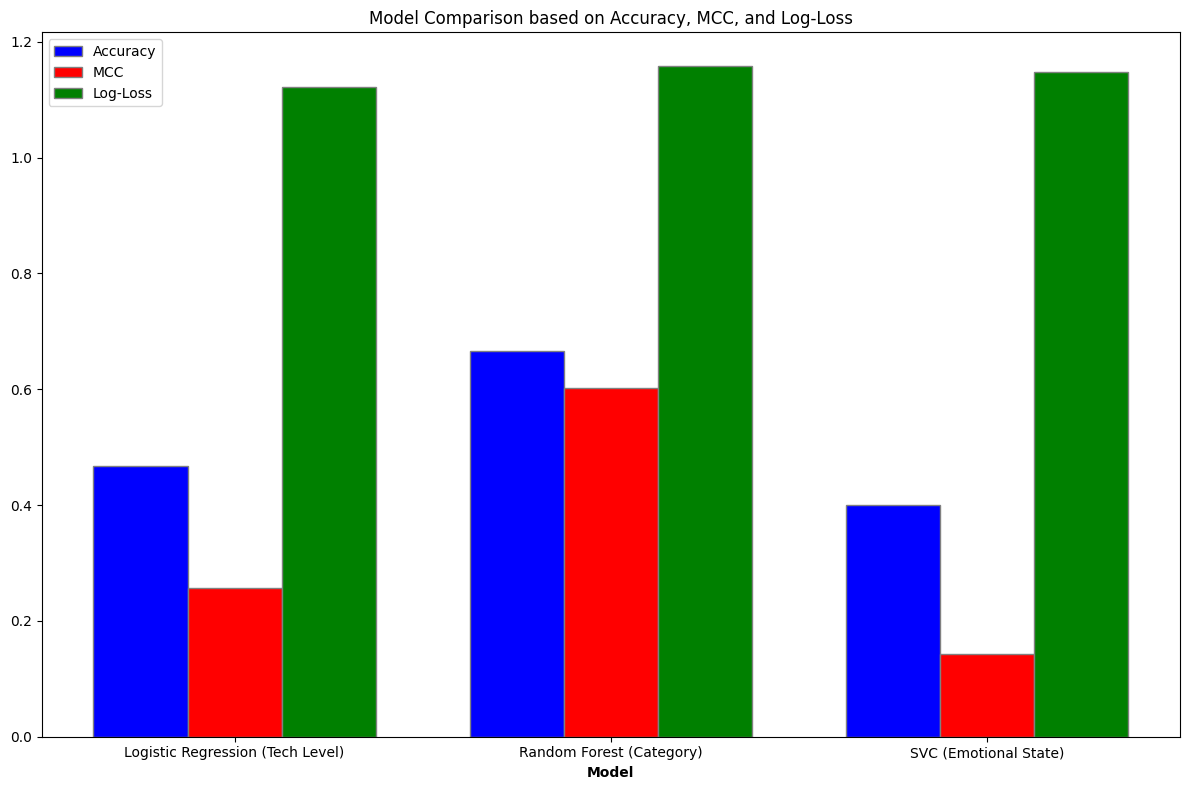

In [23]:
model_names = ['Logistic Regression (Tech Level)', 'Random Forest (Category)', 'SVC (Emotional State)']

# Metrics for each model
accuracies = [tech_accuracy, cat_accuracy, emo_accuracy]
mccs = [tech_mcc, cat_mcc, emo_mcc]
loglosses = [tech_logloss, cat_logloss, emo_logloss]
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Plot
plt.figure(figsize=(12, 8))
plt.bar(r1, accuracies, color='b', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, mccs, color='r', width=barWidth, edgecolor='grey', label='MCC')
plt.bar(r3, loglosses, color='g', width=barWidth, edgecolor='grey', label='Log-Loss')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(accuracies))], model_names)

# Create graphic
plt.legend()
plt.title('Model Comparison based on Accuracy, MCC, and Log-Loss')
plt.tight_layout()
plt.show()